Connect to SQLite Database

In [2]:
import pandas as pd
import numpy as np
import sqlite3

con = sqlite3.connect('/kaggle/input/mental-health-in-the-tech-industry/mental_health.sqlite')

Check Data Validity

In [3]:
# Table 1: Survey
cur = con.cursor()
cur.execute('SELECT * FROM Survey')
df = pd.DataFrame(cur.fetchall(), columns=[d[0] for d in cur.description])
cur.close()
df

,SurveyID,Description
0,2014,mental health survey for 2014
1,2016,mental health survey for 2016
2,2017,mental health survey for 2017
3,2018,mental health survey for 2018
4,2019,mental health survey for 2019


Mental Health survey dataset includes 5 years of survey which are, 2014, 2016, 2017, 2018 and 2019. The year number (SurveyID) is used as Primary Key in this table. No more detail about each survey.

In [4]:
# Table 2: Question
cur = con.cursor()
cur.execute('SELECT * FROM Question')
df = pd.DataFrame(cur.fetchall(), columns=[d[0] for d in cur.description])
cur.close()
df

,questiontext,questionid
0,What is your age?,1
1,What is your gender?,2
2,What country do you live in?,3
3,"If you live in the United States, which state ...",4
4,Are you self-employed?,5
...,...,...
100,Do you think that team members/co-workers woul...,114
101,"If yes, what condition(s) have you been diagno...",115
102,"If maybe, what condition(s) do you believe you...",116
103,Which of the following best describes your wor...,117


In table 2 Question, there are 105 rows of data but the questionid starts with 1 and ends with 118 which is not equal to the number of rows.

*  Check why the number of questionid is not equal to the number of rows

*  Check which questionid is lost.

*  Check if all questions are unique.

In [5]:
# Check why the number of questionid is not equal to the number of rows
# Check which questionid is lost.

# Check that questionid is sequence numbers
cur = con.cursor()
cur.execute('''
WITH cte1 AS (
    SELECT questiontext,
        questionid,
        LAG(questionid, 1) OVER (ORDER BY questionid ASC) AS questionid_above
    FROM Question
)
SELECT *
FROM cte1
WHERE questionid != questionid_above + 1
''')
df = pd.DataFrame(cur.fetchall(), columns=[d[0] for d in cur.description])
cur.close()
df

,questiontext,questionid,questionid_above
0,"If you have a mental health disorder, how ofte...",48,34


questionid is skipped from 34 to 48. So, questionid 35 ~ 47 (13 rows) are lost.

The number of question is 105 questions and 13 rows are skipped. so, it's correct that there are 118 questionid.

! Keep in mind that questionid 35 ~ 47 are not available.

In [6]:
# Check if all questions are unique.
cur = con.cursor()
cur.execute('''
SELECT DISTINCT questiontext
FROM Question
''')
df = pd.DataFrame(cur.fetchall(), columns=[d[0] for d in cur.description])
cur.close()
df

,questiontext
0,What is your age?
1,What is your gender?
2,What country do you live in?
3,"If you live in the United States, which state ..."
4,Are you self-employed?
...,...
100,Do you think that team members/co-workers woul...
101,"If yes, what condition(s) have you been diagno..."
102,"If maybe, what condition(s) do you believe you..."
103,Which of the following best describes your wor...


105 unique questiontext equal to the number of rows in this table. So, every questions are unique.

In [7]:
# Table 3: Answer
cur = con.cursor()
cur.execute('''
SELECT *
FROM Answer
''')
df = pd.DataFrame(cur.fetchall(), columns=[d[0] for d in cur.description])
cur.close()
df

,AnswerText,SurveyID,UserID,QuestionID
0,37,2014,1,1
1,44,2014,2,1
2,32,2014,3,1
3,31,2014,4,1
4,31,2014,5,1
...,...,...,...,...
236893,Other,2016,2689,117
236894,Support,2016,2690,117
236895,Back-end Developer,2016,2691,117
236896,DevOps/SysAdmin,2016,2692,117


Table Answer contains 236,898 rows. AnswerText is what responders answer. SurveyID is Foreign Key from Table Survey. QuestionID is Foreign Key from Table Question. I've no table that UserID is Primary Key so, I've no detail about the responders but able to use UserID as an identifier to distinguish responders.

*  Check that all SurveyID in table Answer exist in table Survey

*  Check that all QuestionID in table Answer exist in table Question

*  Check the number of responsers (unique UserID)

*  Check validity of the answers for each question.

In [8]:
# Check that SurveyID in table Answer exists in table Survey
cur = con.cursor()
cur.execute('''
WITH survey_id_cte AS (
    SELECT DISTINCT SurveyID
    FROM Answer
)
SELECT SurveyID,
    SurveyID IN (SELECT surveyid FROM Survey)
FROM survey_id_cte
''')
df = pd.DataFrame(cur.fetchall(), columns=[d[0] for d in cur.description])
cur.close()
df

,SurveyID,SurveyID IN (SELECT surveyid FROM Survey)
0,2014,1
1,2016,1
2,2017,1
3,2018,1
4,2019,1


All SurveyID in table Answer exist in table Survey

In [9]:
# Check that all QuestionID in table Answer exist in table Question
cur = con.cursor()
cur.execute('''
WITH question_id_cte AS (
    SELECT DISTINCT QuestionID
    FROM Answer
),
check_cte AS (
    SELECT QuestionID,
        QuestionID IN (SELECT questionid FROM Question) AS is_in
    FROM question_id_cte
)
SELECT * FROM check_cte WHERE is_in != 1
''')
df = pd.DataFrame(cur.fetchall(), columns=[d[0] for d in cur.description])
cur.close()
df

,QuestionID,is_in


All QuestionID in table Answer exist in table Question

In [10]:
# Check the number of responsers (unique UserID)
cur = con.cursor()
cur.execute('''
SELECT count(DISTINCT UserID), min(DISTINCT UserID), max(DISTINCT UserID)
FROM Answer
''')
df = pd.DataFrame(cur.fetchall(), columns=[d[0] for d in cur.description])
cur.close()
df

,count(DISTINCT UserID),min(DISTINCT UserID),max(DISTINCT UserID)
0,4218,1,4218


There are 4,218 responders. UserID starts from 1 to 4,218

In [11]:
# Check validity of the answers for each question.

# Sample first 10 answers for each qustion
cur = con.cursor()
cur.execute('''
WITH cte AS (
    SELECT a.*, q.questiontext, row_number() OVER(PARTITION BY a.QuestionID) AS rn
    FROM Answer a
    LEFT JOIN Question q ON a.QuestionID = q.questionid
)
SELECT * FROM cte WHERE rn <= 10
''')
pd.set_option('display.max_rows', None)
df = pd.DataFrame(cur.fetchall(), columns=[d[0] for d in cur.description])
cur.close()
df

,AnswerText,SurveyID,UserID,QuestionID,questiontext,rn
0,37,2014,1,1,What is your age?,1
1,44,2014,2,1,What is your age?,2
2,32,2014,3,1,What is your age?,3
3,31,2014,4,1,What is your age?,4
4,31,2014,5,1,What is your age?,5
5,33,2014,6,1,What is your age?,6
6,35,2014,7,1,What is your age?,7
7,39,2014,8,1,What is your age?,8
8,42,2014,9,1,What is your age?,9
9,23,2014,10,1,What is your age?,10


Some questions could be "Multiple Choices Question" and some could be "Describe Question". Instead of read all answers and questions, I will check how many unique answers there are for each question to decide which question are "Multiple Choices" or "Describe"

In [12]:
# Count unique answers for each question
cur = con.cursor()
cur.execute('''
WITH cte AS(
    SELECT AnswerText, QuestionID, dense_rank() OVER(PARTITION BY QuestionID ORDER BY AnswerText ASC) as denserank_over_questionid
    FROM Answer
),
cte2 AS (
    SELECT QuestionID, max(denserank_over_questionid) AS unique_ans
    FROM cte
    GROUP BY QuestionID
)
SELECT * FROM cte2 ORDER BY unique_ans DESC
''')
df = pd.DataFrame(cur.fetchall(), columns=[d[0] for d in cur.description])
cur.close()
df

,QuestionID,unique_ans
0,86,1020
1,63,457
2,61,449
3,59,353
4,82,337
5,73,306
6,87,287
7,75,269
8,71,229
9,103,160


In general, multiple choices don't exceed 10 choices, check question 17, 28 (8 unique answers) and 80, 89 (11 unique answers) to decide the cut-off point for multiple/describe question.

In [13]:
# Check Question 17
cur = con.cursor()
cur.execute('''
SELECT DISTINCT AnswerText FROM Answer WHERE QuestionID = 17
''')
df = pd.DataFrame(cur.fetchall(), columns=[d[0] for d in cur.description])
cur.close()
df

,AnswerText
0,Very easy
1,Somewhat easy
2,Neither easy nor difficult
3,-1
4,Very difficult
5,Somewhat difficult
6,I don't know
7,Difficult


Question 17 is multiple choices question apparently.

In [14]:
# Check Question 28
cur = con.cursor()
cur.execute('''
SELECT DISTINCT AnswerText FROM Answer WHERE QuestionID = 28
''')
df = pd.DataFrame(cur.fetchall(), columns=[d[0] for d in cur.description])
cur.close()
df

,AnswerText
0,Some of my previous employers
1,I don't know
2,"No, at none of my previous employers"
3,"Yes, at all of my previous employers"
4,-1
5,"Yes, all of my previous supervisors"
6,"No, none of my previous supervisors"
7,Some of my previous supervisors


Question 28 as well

In [15]:
# Check Question 80
cur = con.cursor()
cur.execute('''
SELECT DISTINCT AnswerText FROM Answer WHERE QuestionID = 80
''')
df = pd.DataFrame(cur.fetchall(), columns=[d[0] for d in cur.description])
cur.close()
df

,AnswerText
0,-1
1,3
2,2
3,6
4,0
5,4
6,10
7,7
8,5
9,1


Question 80 as well

In [16]:
# Check Question 89
cur = con.cursor()
cur.execute('''
SELECT DISTINCT AnswerText FROM Answer WHERE QuestionID = 89
''')
df = pd.DataFrame(cur.fetchall(), columns=[d[0] for d in cur.description])
cur.close()
df

,AnswerText
0,-1
1,White
2,More than one of the above
3,Asian
4,Black or African American
5,I prefer not to answer
6,American Indian or Alaska Native
7,Hispanic
8,White Hispanic
9,European American


Question 89 also be able to be multiple choices as well. After looked back to the count unique answer result, count unique answer jumps from 12 to 24. I think 24 is too many for choices. Check Question 116 (24 unique answers)

In [17]:
# Check Question 116
cur = con.cursor()
cur.execute('''
SELECT DISTINCT AnswerText FROM Answer WHERE QuestionID = 116
''')
df = pd.DataFrame(cur.fetchall(), columns=[d[0] for d in cur.description])
cur.close()
df

,AnswerText
0,-1
1,Substance Use Disorder
2,Addictive Disorder
3,"Anxiety Disorder (Generalized, Social, Phobia,..."
4,"Mood Disorder (Depression, Bipolar Disorder, etc)"
5,Attention Deficit Hyperactivity Disorder
6,"Psychotic Disorder (Schizophrenia, Schizoaffec..."
7,"Personality Disorder (Borderline, Antisocial, ..."
8,Obsessive-Compulsive Disorder
9,"Eating Disorder (Anorexia, Bulimia, etc)"


Question 116 is obviously describe question. check Question 64 (12 answers)

In [18]:
# Check Question 64
cur = con.cursor()
cur.execute('''
SELECT DISTINCT AnswerText FROM Answer WHERE QuestionID = 64
''')
df = pd.DataFrame(cur.fetchall(), columns=[d[0] for d in cur.description])
cur.close()
df

,AnswerText
0,6
1,7
2,0
3,-1
4,9
5,10
6,1
7,5
8,3
9,8


From results above, I could say that a question with more than 12 unique answer is a describe question.

Besides, Many answer are -1. I think it could be NULL value but it's returned as -1 in the survey program.

In [19]:
# Create CTE Code to use later for separate which question is choices or describe.
# Count unique answers for each question
cur = con.cursor()
cur.execute('''
WITH cte AS(
    SELECT AnswerText, QuestionID, dense_rank() OVER(PARTITION BY QuestionID ORDER BY AnswerText ASC) as denserank_over_questionid
    FROM Answer
),
cte2 AS (
    SELECT QuestionID, max(denserank_over_questionid) AS unique_ans
    FROM cte
    GROUP BY QuestionID
)
SELECT *,
    IIF(unique_ans > 12, "Describe", "Choices") AS question_type
FROM cte2
''')
df = pd.DataFrame(cur.fetchall(), columns=[d[0] for d in cur.description])
cur.close()
df

,QuestionID,unique_ans,question_type
0,1,65,Describe
1,2,101,Describe
2,3,81,Describe
3,4,51,Describe
4,5,3,Choices
5,6,3,Choices
6,7,2,Choices
7,8,7,Choices
8,9,3,Choices
9,10,6,Choices


Data Analysis ¶

I think I will start from select some interesting questions and get insight from them. But before that, we need some basic info about the data, for example, how many questions used, how many responsers I've got, how many questions used for each year of survey.

In [20]:
# How many question used ?
# I've known that there are 105 questions in total, but it's possible that not all questions are used.

cur = con.cursor()
cur.execute('''
WITH cte AS (
    SELECT DISTINCT SurveyID, QuestionID
    FROM ANSWER
)
SELECT SurveyID, count(QuestionID)
FROM cte
GROUP BY SurveyID
''')
df = pd.DataFrame(cur.fetchall(), columns=[d[0] for d in cur.description])
cur.close()
df

,SurveyID,count(QuestionID)
0,2014,26
1,2016,60
2,2017,76
3,2018,76
4,2019,76


Survey in 2014 used only 26 questions. Survey in 2016 used 60 questions. Survey in 2017, 2018, 2019 used 76 questions.

* Check that in 2017, 2018 and 2019, are the same questions used for each year?

In [21]:
cur = con.cursor()
cur.execute('''
WITH y2014 AS (
    SELECT DISTINCT QuestionID
    FROM ANSWER
    WHERE SurveyID = 2014
    ORDER BY QuestionID
),y2016 AS (
    SELECT DISTINCT QuestionID
    FROM ANSWER
    WHERE SurveyID = 2016
    ORDER BY QuestionID
),y2017 AS (
    SELECT DISTINCT QuestionID
    FROM ANSWER
    WHERE SurveyID = 2017
    ORDER BY QuestionID
),
y2018 AS (
    SELECT DISTINCT QuestionID
    FROM ANSWER
    WHERE SurveyID = 2018
    ORDER BY QuestionID
),
y2019 AS (
    SELECT DISTINCT QuestionID
    FROM ANSWER
    WHERE SurveyID = 2019
    ORDER BY QuestionID
)
SELECT y2014.QuestionID AS "2014",
    y2016.QuestionID AS "2016",
    y2017.QuestionID AS "2017",
    y2018.QuestionID AS "2018",
    y2019.QuestionID AS "2019",
    Question.questionid
FROM y2014
FULL JOIN y2016 ON y2014.QuestionID = y2016.QuestionID
FULL JOIN y2017 ON COALESCE(y2014.QuestionID, y2016.QuestionID) = y2017.QuestionID
FULL JOIN y2018 ON COALESCE(y2014.QuestionID, y2016.QuestionID, y2017.QuestionID) = y2018.QuestionID
FULL JOIN y2019 ON COALESCE(y2014.QuestionID, y2016.QuestionID, y2017.QuestionID, y2018.QuestionID) = y2019.QuestionID
FULL JOIN Question ON COALESCE(y2014.QuestionID, y2016.QuestionID, y2017.QuestionID, y2018.QuestionID, y2019.QuestionID) = Question.questionid
ORDER BY Question.questionid
''')

df = pd.DataFrame(cur.fetchall(), columns=[d[0] for d in cur.description])
cur.close()
df

,2014,2016,2017,2018,2019,questionid
0,1.0,1.0,1.0,1.0,1.0,1
1,2.0,2.0,2.0,2.0,2.0,2
2,3.0,3.0,3.0,3.0,3.0,3
3,4.0,4.0,4.0,4.0,4.0,4
4,5.0,5.0,5.0,5.0,5.0,5
5,6.0,6.0,6.0,6.0,6.0,6
6,7.0,7.0,7.0,7.0,7.0,7
7,8.0,8.0,8.0,8.0,8.0,8
8,9.0,9.0,9.0,9.0,9.0,9
9,10.0,10.0,10.0,10.0,10.0,10


2014 used Question 1 ~ 12, 90 ~ 103

2016 used Question 1 ~ 34, 48 ~ 56, 90 ~ 91, 104 ~ 118

2017, 2018 and 2019 used Question 1 ~ 34, 48 ~ 89

Survey used in 2017, 2018 and 2019 are identical.

First 12 Questions are used in every surveys.

In [22]:
# First 12 Questions used in every surveys.

cur = con.cursor()
cur.execute('''
SELECT * FROM Question WHERE questionid <= 12
''')
df = pd.DataFrame(cur.fetchall(), columns=[d[0] for d in cur.description])
cur.close()
df

,questiontext,questionid
0,What is your age?,1
1,What is your gender?,2
2,What country do you live in?,3
3,"If you live in the United States, which state ...",4
4,Are you self-employed?,5
5,Do you have a family history of mental illness?,6
6,Have you ever sought treatment for a mental he...,7
7,How many employees does your company or organi...,8
8,Is your employer primarily a tech company/orga...,9
9,Does your employer provide mental health benef...,10


Analysis Question 1: Age of responders ¶

* Check min, max of responders' age for each year of survey.

In [23]:
# Analysis Question 1: Age of responders
cur = con.cursor()
cur.execute('''
SELECT SurveyID, min(CAST(AnswerText AS INT)), max(CAST(AnswerText AS INT))
FROM Answer
WHERE questionid = 1 AND CAST(AnswerText AS INT) != -1
GROUP BY SurveyID
''')
df = pd.DataFrame(cur.fetchall(), columns=[d[0] for d in cur.description])
cur.close()
df

,SurveyID,min(CAST(AnswerText AS INT)),max(CAST(AnswerText AS INT))
0,2014,-29,329
1,2016,3,323
2,2017,18,67
3,2018,19,67
4,2019,0,64


Age = -29, 0, 3 or 323, 329 is might be wrong. This is a survey of people in tech industry. The Age should be around 15+ and not exceed 70. Check how many records are unusual.

In [24]:
# Analysis Question 1: Age of responders
cur = con.cursor()
cur.execute('''
SELECT SurveyID, count(*)
FROM Answer
WHERE questionid = 1 AND CAST(AnswerText AS INT) != -1 AND (CAST(AnswerText AS INT) < 15 OR CAST(AnswerText AS INT) > 70)
GROUP BY SurveyID
''')
df = pd.DataFrame(cur.fetchall(), columns=[d[0] for d in cur.description])
cur.close()
df

,SurveyID,count(*)
0,2014,6
1,2016,4
2,2019,1


In [25]:
# Analysis Question 1: Age of responders
cur = con.cursor()
cur.execute('''
SELECT SurveyID, CAST(AnswerText AS INT)
FROM Answer
WHERE questionid = 1 AND CAST(AnswerText AS INT) != -1 AND (CAST(AnswerText AS INT) < 15 OR CAST(AnswerText AS INT) > 70)
''')
df = pd.DataFrame(cur.fetchall(), columns=[d[0] for d in cur.description])
cur.close()
df

,SurveyID,CAST(AnswerText AS INT)
0,2014,-29
1,2014,329
2,2014,5
3,2014,8
4,2014,11
5,2014,72
6,2016,99
7,2016,323
8,2016,3
9,2016,74


only 11 records are weird but age of 72 and 74 is possible. my new criteria will be

1:   not -1

2:   >= 15

3:   <= 74

In [26]:
# Analysis Question 1: Age of responders
cur = con.cursor()
cur.execute('''
SELECT SurveyID, min(CAST(AnswerText AS INT)), max(CAST(AnswerText AS INT))
FROM Answer
WHERE questionid = 1 AND CAST(AnswerText AS INT) != -1 AND CAST(AnswerText AS INT) BETWEEN 15 AND 74
GROUP BY SurveyID
''')
df = pd.DataFrame(cur.fetchall(), columns=[d[0] for d in cur.description])
cur.close()
df

,SurveyID,min(CAST(AnswerText AS INT)),max(CAST(AnswerText AS INT))
0,2014,18,72
1,2016,15,74
2,2017,18,67
3,2018,19,67
4,2019,19,64


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

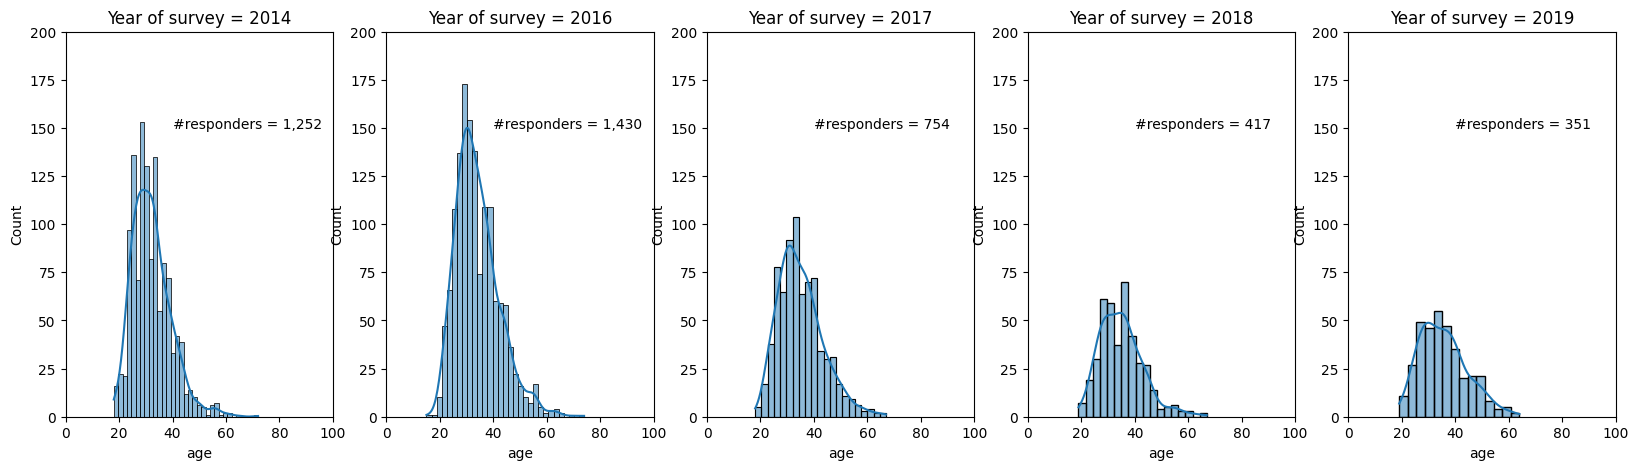

In [27]:
# Histplot for the age
import matplotlib.pyplot as plt
import seaborn as sns

cur = con.cursor()
cur.execute('''
SELECT SurveyID, CAST(AnswerText AS INT) AS age
FROM Answer
WHERE questionid = 1 AND CAST(AnswerText AS INT) != -1 AND CAST(AnswerText AS INT) BETWEEN 15 AND 74
''')
df = pd.DataFrame(cur.fetchall(), columns=[d[0] for d in cur.description])
cur.close()

fig, ax = plt.subplots(1, 5, figsize=(20, 5))
ax = ax.flatten()
for idx, y in enumerate(df['SurveyID'].sort_values().unique()):
    hist = sns.histplot(ax=ax[idx], data=df[df['SurveyID'] == y], x='age', kde=True)
    hist.set_xlim(0, 100)
    hist.set_ylim(0, 200)
    hist.set_title(f'Year of survey = {y}')
    hist.annotate(xy=(40, 150), text='#responders = {:,.0f}'.format(len(df[df['SurveyID'] == y])))
plt.show()

Same trend across surveys. Age of most people is around 25 ~ 40. So, the results are mainly from the viewpoint of Young Adulthood (20 ~ 35 years old)

In [28]:
# Analysis Question 2: Gender
cur = con.cursor()
cur.execute('''
SELECT SurveyID, AnswerText, count(*) AS c
FROM Answer
WHERE questionid = 2 AND AnswerText != -1
GROUP BY SurveyID, AnswerText
ORDER BY c DESC
''')
df = pd.DataFrame(cur.fetchall(), columns=[d[0] for d in cur.description])
cur.close()
df

,SurveyID,AnswerText,c
0,2016,Male,1057
1,2014,Male,991
2,2017,Male,400
3,2016,Female,336
4,2014,Female,247
5,2018,Male,207
6,2019,Male,175
7,2017,Female,155
8,2018,Female,105
9,2017,male,102


I'm not gonna discreminate but there're too many kinds of gender. I'll group it as [Male, Female, Others].

In [30]:
# Analysis Question 2: Gender
cur = con.cursor()
cur.execute('''
WITH cte AS (
    SELECT SurveyID, 
        IIF(lower(AnswerText)='male', 'Male', IIF(lower(AnswerText)='female', 'Female', 'Others')) AS 'Gender'
        , count(*) AS c
    FROM Answer
    WHERE questionid = 2 AND AnswerText != -1
    GROUP BY SurveyID, IIF(lower(AnswerText)='male', 'Male', IIF(lower(AnswerText)='female', 'Female', 'Others'))
    ORDER BY SurveyID, IIF(lower(AnswerText)='male', 'Male', IIF(lower(AnswerText)='female', 'Female', 'Others'))
)
SELECT *, CAST(c AS float) / (SUM(c) OVER(PARTITION BY SurveyID)) * 100
FROM cte
''')
df = pd.DataFrame(cur.fetchall(), columns=[d[0] for d in cur.description])
cur.close()
df

,SurveyID,Gender,c,CAST(c AS float) / (SUM(c) OVER(PARTITION BY SurveyID)) * 100
0,2014,Female,247,19.603175
1,2014,Male,991,78.650794
2,2014,Others,22,1.746032
3,2016,Female,336,23.496503
4,2016,Male,1057,73.916084
5,2016,Others,37,2.587413
6,2017,Female,218,29.340511
7,2017,Male,502,67.563930
8,2017,Others,23,3.095559
9,2018,Female,125,30.193237


Female around 20% ~ 30%, Male around 65% ~ 80%, Others around 2% ~ 7%.

So, around 3/4 of the survey is from the viewpoint of males.

It's interesting that people who describe them as they want (besides Male/Female) increase over the year passed.

In [31]:
# Analysis Question 6: Family with mental illness
cur = con.cursor()
cur.execute('''
SELECT SurveyID, AnswerText, count(*) AS c
FROM Answer
WHERE questionid = 6 AND AnswerText != -1
GROUP BY SurveyID, AnswerText
''')
df = pd.DataFrame(cur.fetchall(), columns=[d[0] for d in cur.description])
cur.close()
df

,SurveyID,AnswerText,c
0,2014,No,768
1,2014,Yes,492
2,2016,I don't know,275
3,2016,No,488
4,2016,Yes,670
5,2017,I don't know,193
6,2017,No,224
7,2017,Yes,339
8,2018,I don't know,95
9,2018,No,114


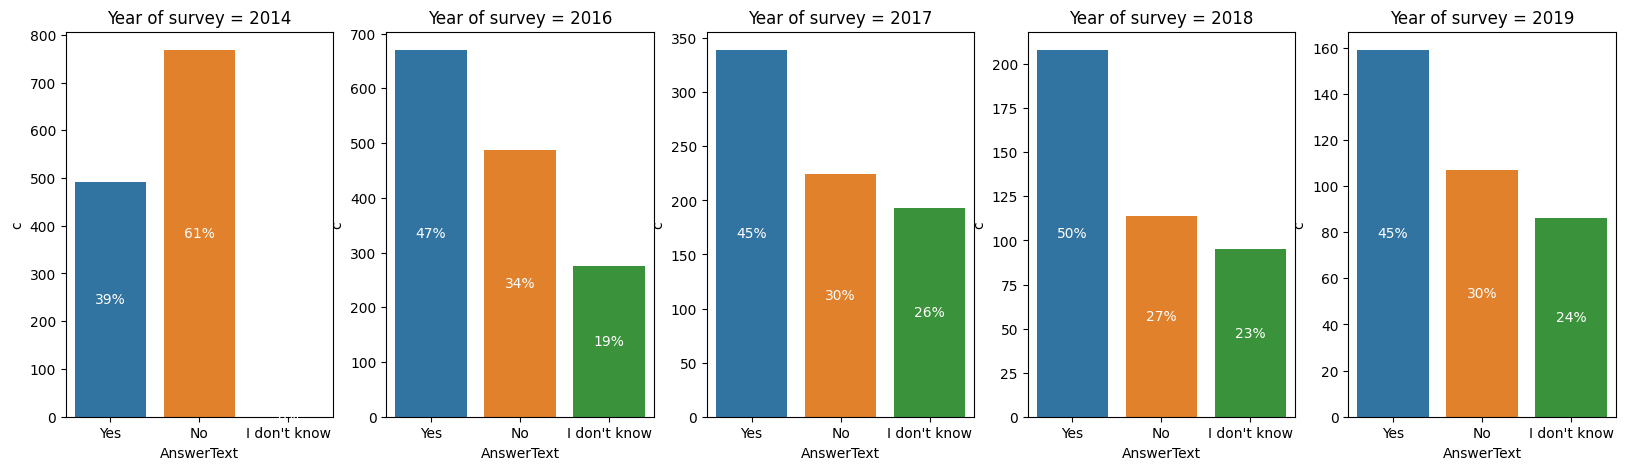

In [32]:
# Analysis Question 6: Family with mental illness
df.loc[14] = [2014, "I don't know", 0]
df

fig, ax = plt.subplots(1, 5, figsize=(20, 5))
ax = ax.flatten()
for idx, y in enumerate(df['SurveyID'].sort_values().unique()):
    bar = sns.barplot(ax=ax[idx], data=df[df['SurveyID'] == y].sort_values(by='AnswerText', ascending=False), x='AnswerText', y='c')
    bar.set_title(f'Year of survey = {y}')
    bar.set_ylabel = 'count'
    bar.set_xlabel = 'Family with mental illness'
    for x, y in enumerate([p.get_height() for p in bar.patches]):
        bar.text(x=x, y=y/2, s='{:.0f}%'.format(y*100/sum([p.get_height() for p in bar.patches])), ha='center', va='center', c='white')
plt.show()

In 2014 survey, it's hard to say that 61% really has no family history in mental illness because there is no choice "I don't know". But, people who have family history of mental illness is around 40% ~ 50% across the surveys which is surprisingly in high level.